<img src="https://jupyter.org/assets/main-logo.svg" heigt=60> <font size="14" color=grey>  DHI Campus - Jupyter Training</font>  

***

# Module 4a: Models - FEFLOW

**Learning Goals:**
    
+ Understands what ifm_contrib is
+ Understand what the difference to ifm and ifm_contrib is
+ Can load a FEFLOW model
+ Can plot simple maps
+ Can extract time series from history charts and FEFLOW time series
+ Can extract and manipulate model properties

**Pre-Reading**
+ Read Article 
+ **Select one of your own projects to use as a test case**
+ Video:  


**Facilitation**

Follow the provided Excel-Spreadsheet for timing!

+ Reception, Welcome, Meet&Greet, Icebreaker

***
**Attention Instructor**: Start of Students Notebook
***

## ifm_contrib

fim_contrib is an Open Source Extension Project for the FEFLOW Programming API. It is publicly hosted on gitub and is avauilable for FEFLOW users both inside and ouside DHI.

The code is free to use, share and modify. It is possible to create a private fork and make proprietary modifications. Users are however encouraged to contribute their own code back to the main branch.

### Installation

ifm_contrib requires an installation of FEFLOW version 7.2. The easiest way to get ifm_contrib is using pip (see below), in this case it will be installed in the packages directory of the currently active python environment:

In [1]:
!pip install ifm_contrib

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


If you want the lastest development version or would like to modify/contribute to the project, you can clone the repository from github into the `/python` subfolder in the FEFLOW program directory (next to the ifm folder).

### General Usage of ifm_contrib

ifm_contrib is code-compatible to ifm, meaning that it inherits all commands and attributes the standard IFM coming with the FEFLOW installation.

Therefore, it can be imported by the same as the ifm:

In [2]:
# import the library
import ifm_contrib as ifm

# set to Viewer mode (allows postprocessing only, but does not require a license).
ifm.forceLicense("Viewer")

True

We open an example FEFLOW results file:

In [3]:
doc = ifm.loadDocument("../data/results/dam_seepage.dac")

### Plotting the model (doc.c.plot)

if you have ever done a DHI FEFLOW training course, you may be familiar with this 2D, cross-sectional model.

If not, I can tell you that the model simulates percolation of water through a levee. The levee's height is 15 m, with a varying water level on its upstream (left side). The levee consists of sand with a core of clay. There are also two pressure probes upstream and downstream of the sealing.

Well, at this point you would probably not really have the picture, and rather ask for a sketch. So let's create one using the API.

the `ifm_contrib.c.plot` contains methods that produce matplotlib figures of model properties. The default style is mostly set to resemble the look and feel of the Slice View of the FEFLOW GUI (yes - caveat: no 3D view as of yet). 

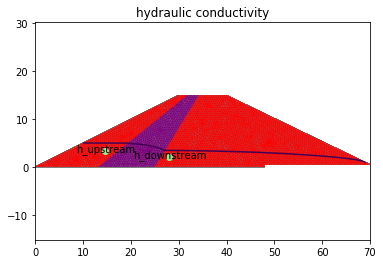

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

doc.c.plot.faces()
doc.c.plot.patches(par=ifm.Enum.P_COND)
doc.c.plot.isolines(par=ifm.Enum.P_PRESS, levels=[0])
doc.c.plot.obs_markers()
doc.c.plot.obs_labels()
plt.axis("equal")
plt.title("hydraulic conductivity")
plt.show()

duplicating the code, we can show the models final results as well:

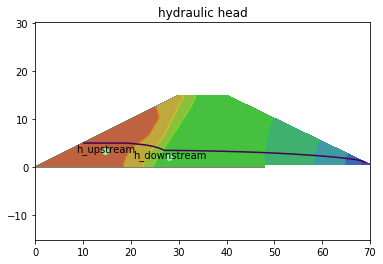

In [5]:
plt.title("hydraulic head")

doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
doc.c.plot.isolines(par=ifm.Enum.P_PRESS, levels=[0])
doc.c.plot.obs_markers()
doc.c.plot.obs_labels()
plt.axis("equal")

plt.show()

... and this can now be automated to show multiple timesteps:

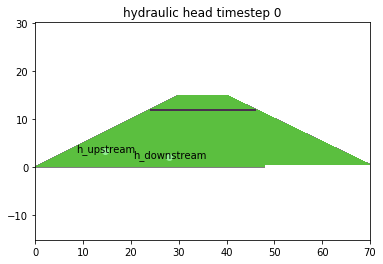

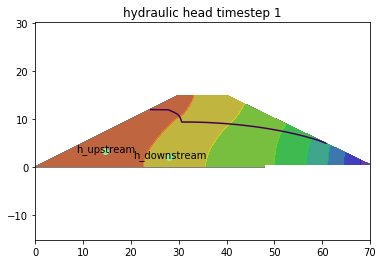

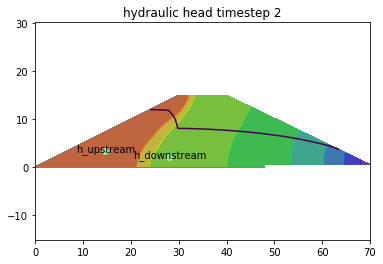

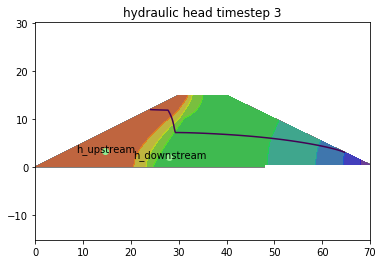

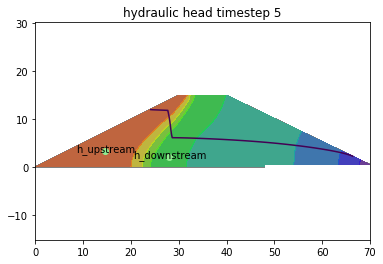

In [6]:
for timestep in [0,1,2,3,5]:
    doc.loadTimeStep(timestep)
    
    plt.title("hydraulic head timestep {}".format(timestep))
    doc.c.plot.faces()
    doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
    doc.c.plot.isolines(par=ifm.Enum.P_PRESS, levels=[0])
    doc.c.plot.obs_markers()
    doc.c.plot.obs_labels()
    plt.axis("equal")
    plt.show()

### Observation points (doc.c.obs)

If you want particular information on the observation points, you can get a list (actually a geodataframe) of all of them:

In [7]:
doc.c.obs.gdf.obspoints()

,label,x,y,z,node,h,conc,shape
id,,,,,,,,
0,h_upstream,14.680441,3.364608,0.0,3120,11.992279,NaN,POINT (14.68044077952379 3.36460823282942)
1,h_downstream,28.050992,2.020742,0.0,1462,6.078846,NaN,POINT (28.05099173893875 2.020742352721604)


###   Accessing History Charts (doc.c.hist)

Now that we can visualize the results in space, have a look at the observations points.
In the FEFLOW GUI you get a history chart for each of them. The ifm_contrib API gives you acces to this data in the form of a data frame:

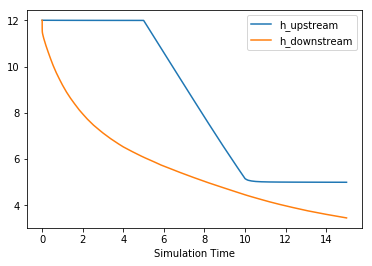

In [8]:
#doc.c.hist.df.history(ifm.Enum.HIST_HEAD).plot()
#doc.c.hist.df.history("HEAD").plot()
doc.c.hist.df.HEAD.plot()

the same accounts for fluxes, with its own history chart.

Note that fluxes are often unstable on the first time steps and that its reading s often meaningless, so we want to omit the first time step. Because the we are working with a DataFrame, this is straight forward using the dataframes ´.iloc[]´ method. 

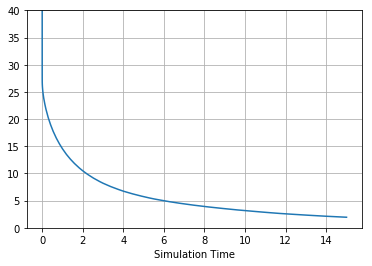

In [9]:
ax = (-doc.c.hist.df.FFLUX.iloc[1:].q_seepage).plot()  # returns an axis which we can then modify
ax.set_ylim(0, 40) # set different y-axis
plt.grid()

a typical task is checking for the models imbalance. This is best shown as integral values:

Text(0,0.5,'water volume [m3]')

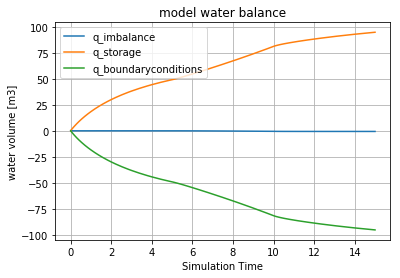

In [10]:
doc.c.hist.df.FFLUX_I[[u'q_imbalance', u'q_storage',
       u'q_boundaryconditions']].plot()
plt.grid()
plt.title("model water balance")
plt.ylabel("water volume [m3]")

## Time series data (doc.c.ts)

In a similar way, the ifm_contrib API allow exporting time series data (as you find them in the Time Series Editor of the FEFLOW GUI).

There is a difference thus, as time series are not necessarily synchronous (while history charts always share the same time axis, which are the models time steps). Therefore, it is not possible to create one large table for all time series, but they time series are exported one-by-one.

First, we check which time series the model actually contains: 

In [11]:
doc.c.ts.df.info()

,comment,no_point,interpolation_kind,is_cyclic
tsid,,,,
1,reservoir_level,4,2,False
105,something_else,2,2,False


So, there is one time series (which controls the reservoir level on the left side. We can then retrieve the data points by using its tsid:

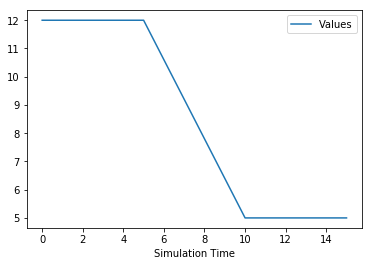

In [12]:
doc.c.ts.df.points(1).plot()

Finally, we want to combine the reservoir level BC, downstream head and reservoir flux to put them in perspective:

(-40, 20)

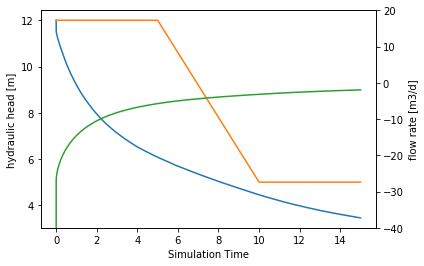

In [13]:
ax1 = doc.c.hist.df.HEAD.h_downstream.plot()
doc.c.ts.df.points(1).Values.plot(ax=ax1, label="reservoir level")
ax1.set_ylabel("hydraulic head [m]")
ax2 = doc.c.hist.df.FFLUX.q_seepage.iloc[1:].plot(secondary_y = True)
ax2.set_ylabel("flow rate [m3/d]")
ax2.set_ylim(-40, 20) # set different y-axis


HINT: These functions return a calendar (datetime) axis if the reference date is set in FEFLOW (either in the GUI (Problem Settings), or by setting it using the API:

In [14]:
# set the Reference Time to Excel time:
import datetime
doc.pdoc.setReferenceTime(datetime.datetime(1899, 12, 31))

(-40, 20)

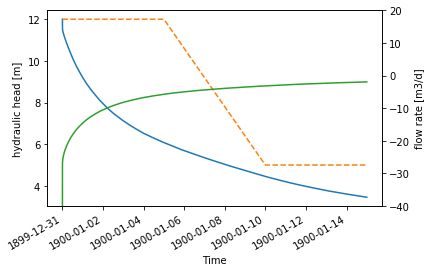

In [15]:
ax1 = doc.c.hist.df.HEAD.h_downstream.plot()
doc.c.ts.df.points(1).Values.plot(ax=ax1, style="--", label="reservoir level")
ax1.set_ylabel("hydraulic head [m]")
ax2 = doc.c.hist.df.FFLUX.q_seepage.iloc[1:].plot(secondary_y = True)
ax2.set_ylabel("flow rate [m3/d]")
ax2.set_ylim(-40, 20) # set different y-axis


## Nodal and Elemental Data (doc.c.mesh)

The API can export DataFrames with all elemental or nodal values, including model properties of the following kinds:
+ model properties (process variables, boundary conditions and material parameters)
+ user distributions
+ user expressions

For example, the following commands gets all elemental values of hydr. conductivity, and plots a histogram of the parameters distribution (this is the same as if using the *parameter statistics* feature in the FEFLOW GUI).

In [16]:
doc.c.mesh.df.elements(par={"COND" : ifm.Enum.P_COND}).head()

,LAYER,TOP_ELEMENT,COND
ELEMENT,,,
0,1,0,8.64
1,1,1,8.64
2,1,2,8.64
3,1,3,8.64
4,1,4,8.64


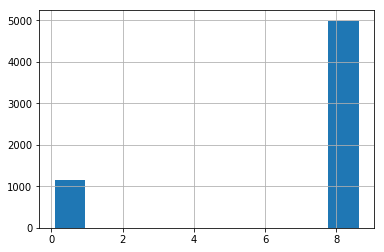

In [17]:
doc.c.mesh.df.elements(par={"COND" : ifm.Enum.P_COND}).COND.hist()

if you wonder how to **assign**  data, hold on, we will come to that.

the ifm_contrib API can also export GeoDataFrames:

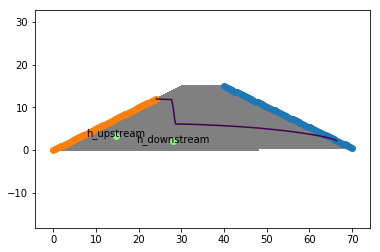

In [18]:
# base figure (copied from above)
doc.c.plot.faces()
doc.c.plot.isolines(par=ifm.Enum.P_PRESS, levels=[0])
doc.c.plot.obs_markers()
doc.c.plot.obs_labels()
plt.axis("equal")

# add the two selections:
doc.c.mesh.gdf.nodes(selection="q_seepage").plot(ax=plt.gca())
doc.c.mesh.gdf.nodes(selection="q_reservoir").plot(ax=plt.gca())

plt.show()

## Selections (doc.c.sel)

Selections can be obtained from the API in the following way. First, we check which selections to exist: (note: this list does not differentiate between the types of selection)

In [19]:
# get all selection names (note:)
doc.c.sel.getSelectionNames()

['q_seepage',
 'q_reservoir',
 'q_drain',
 'q_imbalance',
 'q_storage',
 'q_boundaryconditions',
 'q_sources',
 'Sealing',
 'Body',
 'Domain',
 '<current>']

... and get a list of item numnbers, for example all items of the *Sealing* of the dam. 

In [20]:
doc.c.sel.list('Sealing')[:10]

[3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839]

This works nicely in combination with the mesh-dataframes demonstrated above, as we can use the item lists as indexers of the dataframe.

Example 1: Get Parameter Statistics of a particular selection only: 

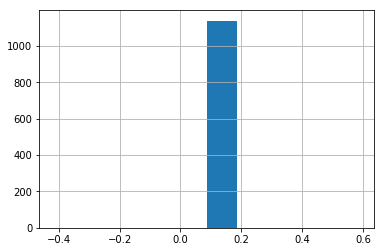

In [21]:
df_elements = doc.c.mesh.df.elements(par={"COND" : ifm.Enum.P_COND})
df_elements.loc[doc.c.sel.list('Sealing')].COND.hist()

Example 2: assign new parameter value to a particular selection

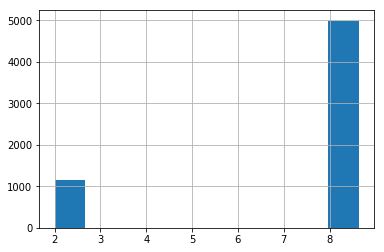

In [22]:
# get the DataFrame with all elements
df_elements = doc.c.mesh.df.elements(par={"COND" : ifm.Enum.P_COND})

# assign a new conductivity value to elements of the selection:
df_elements.loc[doc.c.sel.list('Sealing')] = 2.  # 2 m/d for a high conductive Sealing  

# apply the complete vector to the model
doc.setParamValues(ifm.Enum.P_COND, list(df_elements.COND))

# check the result with another parameter statistic
doc.c.mesh.df.elements(par={"COND" : ifm.Enum.P_COND}).COND.hist()

### Further Features

The complete set of features of the ifm_contrib is described in the help system on https://dhi.github.io/ifm_contrib/.

Especially, check out the list of methods:
https://dhi.github.io/ifm_contrib/ifm_contrib.contrib_lib.html

### Missing Features

If you are missing any features, and you are an able programmer, we would be happy if you could contribute this feature (please send pull request). If you are not comfortable, file a feature request on [github.com/dhi/ifm_contrib](https://github.com/dhi/ifm_contrib/issues).